In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [7]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, holistic_model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = holistic_model.process(image)        # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def extract_keypoints(results, image):
    # Trích xuất tọa độ x, y của ngón trỏ (index 8)
    if results.left_hand_landmarks:
        # Lấy tọa độ ngón trỏ (điểm mốc thứ 8)
        index_finger = results.left_hand_landmarks.landmark[8]
        return np.array([index_finger.x, index_finger.y])  # Tọa độ x, y của ngón trỏ
    else:
        # Nếu không phát hiện tay trái, trả về [0, 0]
        return np.zeros(2)


def draw_styled_landmarks(image, results):
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def normalize_points(points):
    origin = points[0]
    normalized_points = points - origin
    return normalized_points

In [9]:
def save_keypoints(action, videoCounter, keypoints):
    npy_dir = os.path.join('new_data_npy', action)
    os.makedirs(npy_dir, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại
    
    # Lưu keypoints vào tệp .npy
    npy_path = os.path.join(npy_dir, f'{videoCounter}.npy')
    np.save(npy_path, keypoints)
    print(f'{action}: saving frame of video {videoCounter}')

In [10]:
def process_npy(action):    
    # Khởi tạo mô hình Mediapipe Holistic
    with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
        
        # Lấy danh sách tất cả video trong thư mục của action cụ thể
        video_folder = f'data/{action}'
        videos = [f for f in os.listdir(video_folder) if f.endswith('.avi')]
        
        for videoCounter, videoFile in enumerate(videos):
            cap = cv2.VideoCapture(os.path.join(video_folder, videoFile))
            framesCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            points = []
            # Không cần skip frame nữa, xử lý tất cả frame
            for frameCounter in range(framesCount):  # Xử lý tất cả các frame trong video
                ret, frame = cap.read()
                
                if not ret:
                    break  # Nếu không đọc được frame thì dừng
                
                # Chạy Mediapipe để phát hiện landmarks
                image, results = mediapipe_detection(frame, holistic)
                
                # Hiển thị kết quả (có thể bỏ qua nếu không cần thiết)
                # cv2.imshow('OpenCV Feed', image)
                
                # Trích xuất keypoints từ kết quả Mediapipe
                keypoints = extract_keypoints(results, image)
                
                points.append(keypoints)
                
            points = np.array(points)
            # points = normalize_points(points)
            
            save_keypoints(action, videoCounter, points)
                
            # Nếu nhấn 'q', thoát khỏi quá trình xử lý
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
            
            # Giải phóng tài nguyên video sau khi xử lý xong
            cap.release()
    
    # Đóng tất cả cửa sổ OpenCV
    cv2.destroyAllWindows()

In [11]:
classes = ['idle', 'up', 'down', 'left', 'right']

label_map = {label:num for num, label in enumerate(classes)}
label_map

{'idle': 0, 'up': 1, 'down': 2, 'left': 3, 'right': 4}

In [24]:
data = np.load('../movement_check/new_data_normalized/movement/14.npy')
print(data)

[[0.72160521 1.        ]
 [0.43718937 0.90516667]
 [0.14521473 0.70020146]
 [0.         0.49961119]
 [0.19938255 0.4675066 ]
 [0.44689059 0.26748477]
 [0.29029915 0.11680068]
 [0.22247918 0.06152418]
 [0.18875493 0.        ]
 [0.66624395 0.26308926]
 [0.41096521 0.22219446]
 [0.36117779 0.44359269]
 [0.3950975  0.55789471]
 [0.84704673 0.32424285]
 [0.5708485  0.36687228]
 [0.51836531 0.5883126 ]
 [0.55693074 0.6927442 ]
 [1.         0.42199497]
 [0.75940711 0.46798324]
 [0.69364969 0.61356545]
 [0.7181742  0.68279444]]


In [12]:
def create_dataset():
    data, labels = [], []

    # Duyệt qua tất cả các lớp hành động
    for action in classes:
        # Thư mục chứa các file .npy của lớp hành động
        action_folder = os.path.join('data_npy', action)
        
        if not os.path.exists(action_folder):
            print(f"Thư mục {action_folder} không tồn tại.")
            continue

        # Lấy danh sách các file .npy trong lớp hành động, sắp xếp theo thứ tự
        npy_files = sorted([f for f in os.listdir(action_folder) if f.endswith('.npy')], key=lambda x: int(x.split('.')[0]))
        
        print(f"Đang xử lý {len(npy_files)} files cho lớp {action}.")
        
        # Duyệt qua từng file .npy và lưu dữ liệu
        for npy_file in npy_files:
            file_path = os.path.join(action_folder, npy_file)
            features = np.load(file_path)  # Đọc file .npy
            data.append(features)
            labels.append(label_map[action])  # Gắn nhãn tương ứng với hành động

    return np.array(data), np.array(labels)

sequences, labels = create_dataset()

print(f"Tổng số sequences: {len(sequences)}")
print(f"Tổng số labels: {len(labels)}")
print(f"Shape của sequences: {np.array(sequences).shape}")
print(f"Shape của labels: {np.array(labels).shape}")

# print(sequences, labels)

Đang xử lý 500 files cho lớp idle.
Đang xử lý 500 files cho lớp up.
Đang xử lý 500 files cho lớp down.
Đang xử lý 504 files cho lớp left.
Đang xử lý 506 files cho lớp right.
Tổng số sequences: 2510
Tổng số labels: 2510
Shape của sequences: (2510, 15, 2)
Shape của labels: (2510,)


In [13]:
np.save("data.npy", sequences)
np.save("labels.npy", labels)

In [12]:
X = np.load('data.npy')
y = np.load('labels.npy')

print(X.shape)
print(y)

(2510, 15, 2)
[0 0 0 ... 4 4 4]


In [13]:
# y = to_categorical(y, num_classes=len(classes))
print(y)

[0 0 0 ... 4 4 4]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_test.shape

# print(y_train)

(502,)

In [15]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(15, 2)))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.summary()

d:\Phong\Coding\GestureRecognition\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 64)         │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,549 (486.52 KB)

 Trainable params: 124,549 (486.52 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Tạo callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4375 - loss: 1.5554 - val_accuracy: 0.5423 - val_loss: 1.2496
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5804 - loss: 1.1897 - val_accuracy: 0.6468 - val_loss: 0.9118
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6754 - loss: 0.8775 - val_accuracy: 0.6269 - val_loss: 0.9654
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6822 - loss: 0.8285 - val_accuracy: 0.7886 - val_loss: 0.6016
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7505 - loss: 0.6854 - val_accuracy: 0.7761 - val_loss: 0.6422
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7177 - loss: 0.7414 - val_accuracy: 0.8259 - val_loss: 0.5206
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8108 - loss: 0.5529 - val_accuracy: 0.7910 - val_loss: 0.5307
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7628 - loss: 0.6411 - val_accuracy: 0.

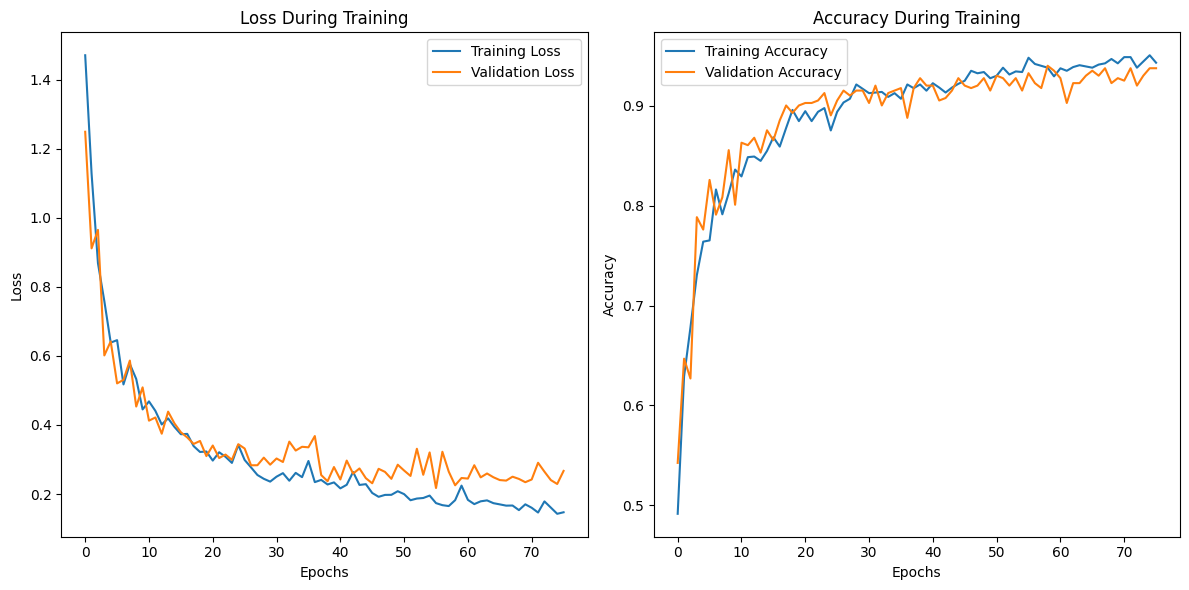

In [17]:
# Plot the loss and accuracy graphs together
plt.figure(figsize=(12, 6))

# Plot the loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
yhat = np.argmax(model.predict(X_test), axis=1)

# print(yhat)

conf_matrix = confusion_matrix(y_test, yhat)
print(conf_matrix)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
[[ 93   8   3   0   1]
 [  4  91   1   1   0]
 [  9   3  89   0   0]
 [  1   4   0  83   2]
 [  0   3   0   0 106]]


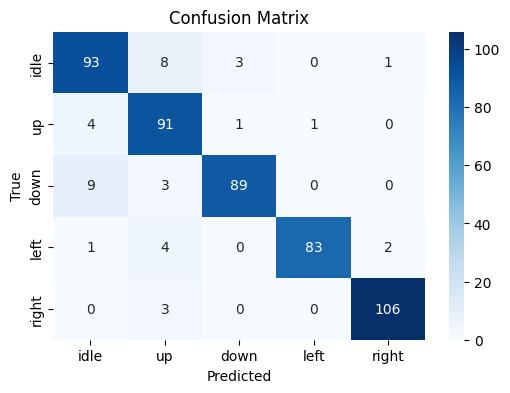

In [19]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
acc = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat, average='micro')
recall = recall_score(y_test, yhat, average='micro')
f1 = f1_score(y_test, yhat, average='micro')
report = classification_report(y_test, yhat, output_dict=True)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Báo cáo phân loại:")
print(classification_report(y_test, yhat, target_names=classes))

Accuracy: 0.9203
Precision: 0.9203
Recall: 0.9203
F1 Score: 0.9203
Báo cáo phân loại:
              precision    recall  f1-score   support

        idle       0.87      0.89      0.88       105
          up       0.83      0.94      0.88        97
        down       0.96      0.88      0.92       101
        left       0.99      0.92      0.95        90
       right       0.97      0.97      0.97       109

    accuracy                           0.92       502
   macro avg       0.92      0.92      0.92       502
weighted avg       0.92      0.92      0.92       502



In [39]:
colors = [(245,117,16), (117,245,16), (16,117,245), (16,234,245), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [40]:
# 1. New detection variables
keys = []
sentence = []
predictions = []
threshold = 0.7
frame_counter = 0  # Khởi tạo biến đếm

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        frame_counter += 1  # Tăng biến đếm lên mỗi khi đọc khung hình
        if frame_counter % 2 != 0:  # Chỉ xử lý mỗi khung hình thứ 3 (tùy chỉnh)
            continue

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results, image)
        
        keys.append(keypoints)
        sequence = np.array(keys[-15:])
        sequence = normalize_points(sequence)
        
        if len(sequence) == 15:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(np.argmax(res))
            print(classes[np.argmax(res)])
            predictions.append(np.argmax(res))

            # Viz probabilities
            image = prob_viz(res, classes, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

d:\Phong\Coding\HandTracking\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
0
idle
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0
idl

In [25]:
model.save('movement_direction2.keras')